## Exploring pytorch models and BTC predictions

from: https://www.kaggle.com/datasets/novandraanugrah/bitcoin-historical-datasets-2018-2024?resource=download

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

In [3]:
df_daily = pd.read_csv("../data/bitcoin-historical-datasets/btc_1d_data_2018_to_2025.csv")
df_daily = df_daily.set_index('Open time')

In [4]:
df_daily.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Ignore'],
      dtype='object')

In [5]:
timeseries = df_daily[['Close']].values.astype('float32')
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

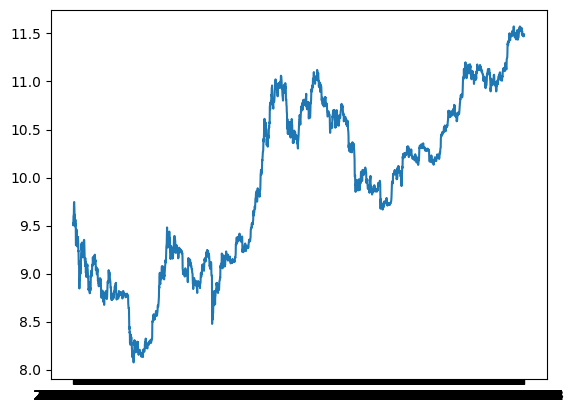

In [18]:
#ax = df_daily.plot(y="Open",rot = 90)

plt.plot(df_daily.index, np.log(df_daily['Open']))
plt.show()

In [10]:
df_daily['Open']

Open time
2018-01-01    13715.65
2018-01-02    13382.16
2018-01-03    14690.00
2018-01-04    14919.51
2018-01-05    15059.56
                ...   
2025-02-11    97430.82
2025-02-12    95778.21
2025-02-13    97870.00
2025-02-14    96608.13
2025-02-15    97500.47
Name: Open, Length: 2603, dtype: float64

In [13]:
np.log10(df_daily['Close'])

Open time
2018-01-01    4.126456
2018-01-02    4.166581
2018-01-03    4.173755
2018-01-04    4.177812
2018-01-05    4.229436
                ...   
2025-02-11    4.993265
2025-02-12    4.983085
2025-02-13    4.990433
2025-02-14    4.985459
2025-02-15    4.989601
Name: Close, Length: 2603, dtype: float64

In [26]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [27]:
lookback = 12
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1732, 12, 1]) torch.Size([1732, 12, 1])
torch.Size([847, 12, 1]) torch.Size([847, 12, 1])


In [ ]:
import torch.nn as nn
 
class BTCModelLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [31]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = BTCModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 20000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

/tmp/ipykernel_25571/1002121640.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
/tmp/ipykernel_25571/1002121640.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 26858.9492, test RMSE 53365.3828
Epoch 100: train RMSE 26654.7266, test RMSE 53127.2344
Epoch 200: train RMSE 26451.8867, test RMSE 52889.6523
Epoch 300: train RMSE 26250.5781, test RMSE 52652.7734
Epoch 400: train RMSE 26050.5801, test RMSE 52416.3164
Epoch 500: train RMSE 25852.1250, test RMSE 52180.5312
Epoch 600: train RMSE 25655.1250, test RMSE 51945.2930
Epoch 700: train RMSE 25459.7734, test RMSE 51710.8008
Epoch 800: train RMSE 25266.1465, test RMSE 51477.1289
Epoch 900: train RMSE 25074.0684, test RMSE 51244.0273
Epoch 1000: train RMSE 24883.7246, test RMSE 51011.7070
Epoch 1100: train RMSE 24695.0508, test RMSE 50780.0625
Epoch 1200: train RMSE 24508.1367, test RMSE 50549.1680
Epoch 1300: train RMSE 24322.9414, test RMSE 50318.9414
Epoch 1400: train RMSE 24139.5938, test RMSE 50089.5312
Epoch 1500: train RMSE 23957.8828, test RMSE 49860.6250
Epoch 1600: train RMSE 23778.0234, test RMSE 49632.4609
Epoch 1700: train RMSE 23600.3301, test RMSE 49405.4219
Epoc

/tmp/ipykernel_25571/3103842424.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  train_plot[lookback:train_size] = model(X_train)[:, -1, :]
/tmp/ipykernel_25571/3103842424.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


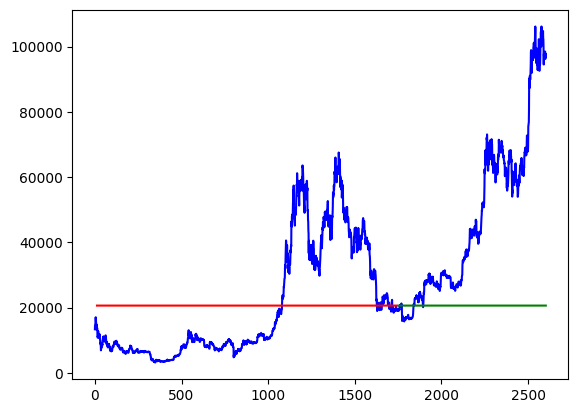

In [32]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()